## Imports

In [120]:
import os
import sys
import multiprocessing
import logging

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.getLogger()
logger.setLevel(logging.INFO)

cpu_count = multiprocessing.cpu_count()
print("Available cores:", cpu_count)

Available cores: 12


In the next cell, the user provides the input files and configures options for the analysis.

- `PATH_TO_COUNT_DATA`: Raw, unnormalized count matrix used as input for DESeq2 or edgeR. For now, input data must have two conditions with the same number of replicates.
  
- `PATH_TO_META_DATA`: Data frame with condition factor and covariates to control for. The index must match the columns of count data. The last column must be called "Condition". Any additional columns are assumed to be covariates to control for.
  
- `TRIALS`: Total number of bootstrap trials. If this number is increased later, new results will be appended to existing results until the desired number of trials s reached.

In the example data provided, we compare two breast cancer subtypes: basal-like and luminal A, with $n=5$ replicates each. The analysis is controlled for tumor purity and age. Data is obtained from TCGA.

In [109]:
PATH_TO_COUNT_DATA = "../data/BSLA.N5.csv"
PATH_TO_META_DATA = "../data/BSLA.N5.meta.csv"
NAME = "BSLA.N5" # name to tag output files with
SAVE_PATH = "../data/" # recommended to save in custom folder
TRIALS = 25
METHOD = "edgeR" # deseq2 or edgeR
LFC = 1 # formal log fold change threshold used for DEG testing
FDR = 0.05 # adjusted p-value to define DEGs

In [110]:
counts = pd.read_csv(PATH_TO_COUNT_DATA, index_col=0)
display(counts.head())

meta = pd.read_csv(PATH_TO_META_DATA, index_col=0)
meta.head()

,Basal18,Basal73,Basal98,Basal103,Basal109,LumA18,LumA73,LumA98,LumA103,LumA109
ENSG00000000003,6807,5526,2056,2509,2881,17957,580,1100,1598,850
ENSG00000000419,3229,3191,4408,2492,1503,2637,3273,2200,1316,1680
ENSG00000000457,1444,1264,329,1096,519,1883,2250,2375,1002,1559
ENSG00000000460,1416,1274,289,881,844,675,896,779,471,402
ENSG00000000938,588,582,428,4129,309,443,860,284,110,334


,TumorPurity,days_to_birth,Condition
Sample,,,
Basal18,0.54,-17981.0,Basal
Basal73,0.57,-21575.0,Basal
Basal98,0.69,-22115.0,Basal
Basal103,0.17,-24319.0,Basal
Basal109,0.48,-23230.0,Basal


## Run DEA on original cohort

In future versions, users will be able to specify their own R (or Python) script to run bootstrapping. For now, we demonstrate the method assuming the user has DESeq2 or edgeR installed.

In [111]:
from DEA import run_dea

OUTFILE_ORIGINAL = Path(SAVE_PATH) / f"{NAME}.original.{METHOD}.lfc{LFC}.csv" 
run_dea(counts, 
        outfile = OUTFILE_ORIGINAL, 
        method = METHOD, 
        design = PATH_TO_META_DATA,
        lfc = LFC,
        overwrite = False
        )

[1] "Existing table not overwritten"


Let's inspect the results from the original cohort before bootstrapping:

DEGs: 340 | Upregulated: 169 | Downregulated: 171


,logFC,unshrunk.logFC,logCPM,PValue,FDR
ENSG00000163064,-8.283928,-8.290876,5.916537,7.633095e-09,0.000139
ENSG00000171428,7.075747,7.076710,7.482737,6.316457e-08,0.000574
ENSG00000204385,8.281362,8.284972,6.773184,1.370099e-06,0.008306
ENSG00000150667,6.523369,6.532826,4.571879,2.567195e-06,0.009381
ENSG00000259459,8.623593,8.671622,3.264028,2.638531e-06,0.009381


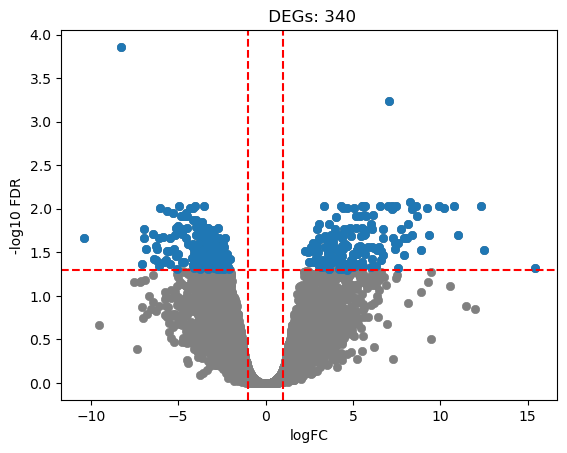

In [112]:
from plotting import make_volcano

tab = pd.read_csv(OUTFILE_ORIGINAL, index_col=0)
sig = tab[tab["FDR"]<FDR]
up = sig[sig["logFC"]>LFC]
down = sig[sig["logFC"]<-LFC]
print(f"DEGs: {len(sig)} | Upregulated: {len(up)} | Downregulated: {len(down)}")
display(tab.head())
make_volcano(tab, lfc=LFC, FDR=FDR)

## Run bootstrapped DEA

In [162]:
from bootstrap import bootstrap_data
bootstrap_data(df = counts,
                save_path = SAVE_PATH,
                lfc = LFC,
                design = "custom",
                method = METHOD,
                name = NAME,
                trials = TRIALS,
                meta=meta, 
                logfile=f"{SAVE_PATH}/log.txt",
                maxiter=5
                )


# Remove intermediate results
os.system(f"rm {SAVE_PATH}/tmp/*")

INFO:root:Already have 25 trials, returning
rm: cannot remove '../data//tmp/*': No such file or directory


256

## Inspect results

The bootstrapping returns a long dataframe with all trial results concatenated:

In [163]:
results_file = f"{SAVE_PATH}/{NAME}.boot.trials{TRIALS}.{METHOD}.csv"
tab_boot = pd.read_csv(results_file, index_col=0)
tab_boot.tail()

,logFC,unshrunk.logFC,logCPM,PValue,FDR,Trial
ENSG00000168228,0.448439,0.448568,3.099712,1.0,1.0,25
ENSG00000247708,-0.241050,-0.241198,2.106496,1.0,1.0,25
ENSG00000173928,0.117633,0.117661,1.770706,1.0,1.0,25
ENSG00000186312,0.064509,0.064616,1.896503,1.0,1.0,25
ENSG00000231721,-0.032735,-0.032767,1.629239,1.0,1.0,25


We now calculate Spearman rank correlations of the logFC estimates between the bootstrapped and original data sets:

In [166]:
from bootstrap import compute_spearmans
spearmans = compute_spearmans(tab_reference=tab, bootstrap_results=tab_boot)
print(f"Median Spearman: {np.median(spearmans):.3f}")
print(f"Standard deviation: {np.std(spearmans):.3f}")

Median Spearman: 0.890
Standard deviation: 0.071


In the original study by Degen and Medo (2025), we found that Spearman correlations above ~0.9 yield generally reliable results. Conversely, if correlations are lower then ~0.8, we recommend interpreting differential expression and enrichment results with caution.

We can also compare the computed Spearman correlations with the results from our original study.

Figsize (8.928, 13.64)


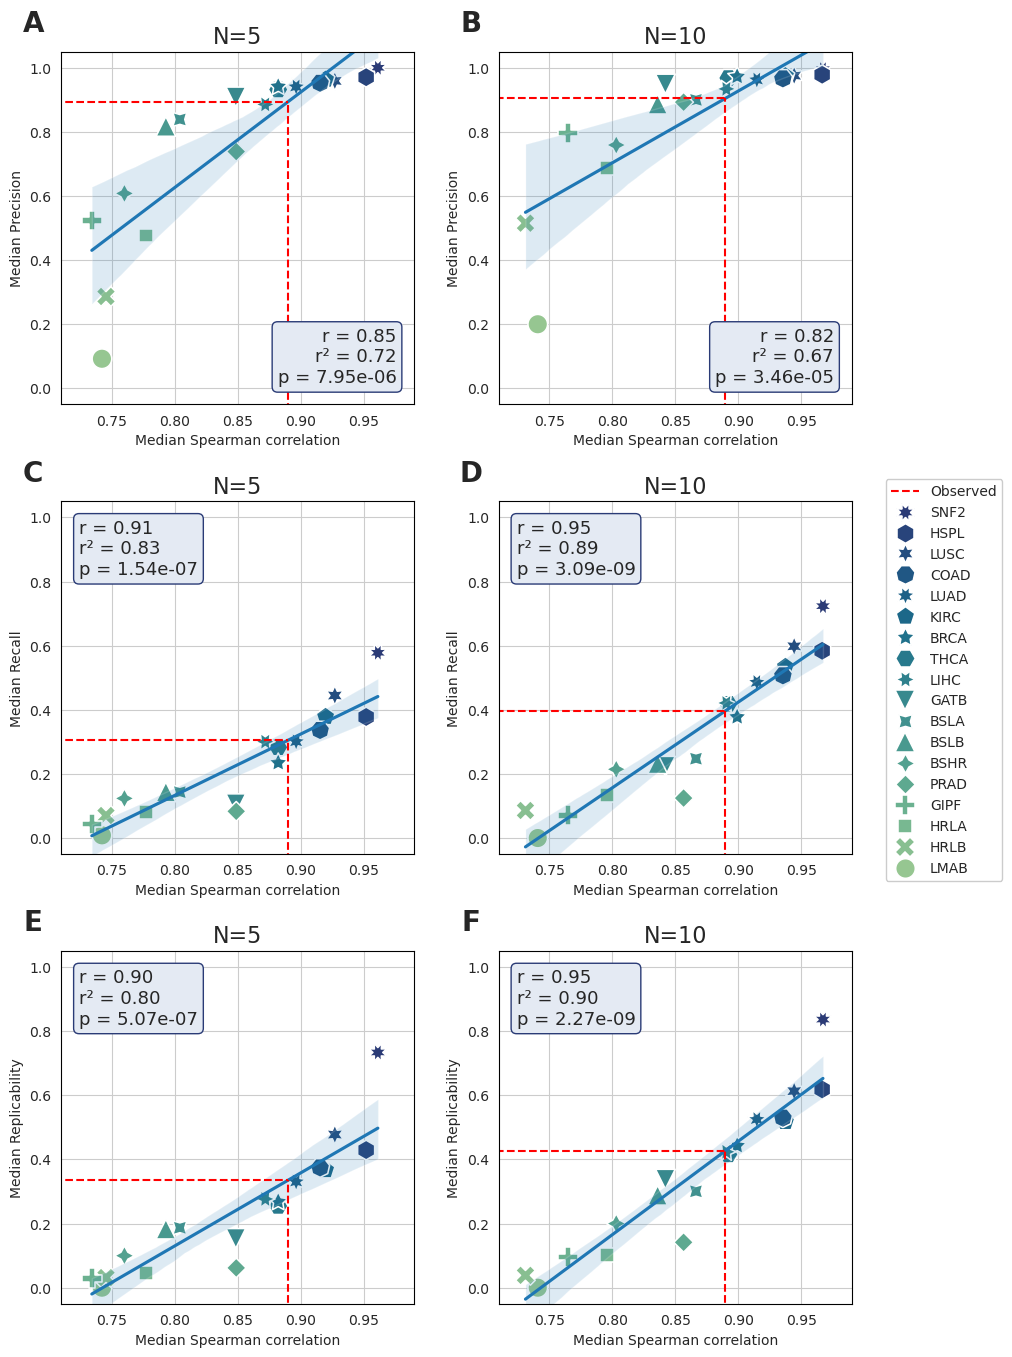

In [189]:
from plotting import compare_plot

fig = compare_plot(observed_val=np.median(spearmans))
fig.tight_layout()

In [188]:
import sys, importlib
importlib.reload(sys.modules["plotting"])

<module 'plotting' from '/home/peter/Work/OmicsPhD/BootstrapSeq/src/plotting.py'>